<a href="https://colab.research.google.com/github/deguc/datascience/blob/main/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

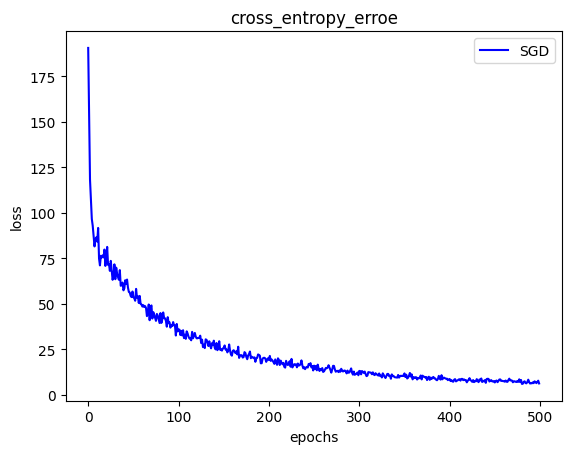

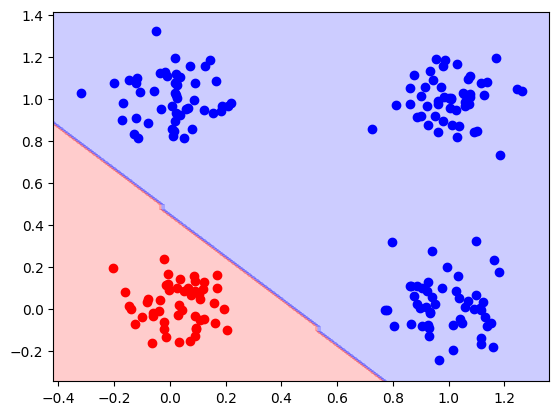

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#色々な学習方法を比較する。

def MakeData(y=[0,1,1,1],N=50,loc=0,scale=0.05):

  #N=10         データのサイズ
  #loc          平均
  #scale=0.05   標準偏差

  X_=np.array([[0,0],[0,1],[1,0],[1,1]])#学習用データ

  #元のデータにノイズを足す。
  X0=X_[0]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X1=X_[1]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X2=X_[2]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X3=X_[3]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X=np.concatenate((X0,X1,X2,X3))   #データを結合する。

  #正解ラベル
  y0=np.full(N,y[0])
  y1=np.full(N,y[1])
  y2=np.full(N,y[2])
  y3=np.full(N,y[3])
  y=np.concatenate((y0,y1,y2,y3))   #データを結合する

  return X,y

def plot(X,y,c=['red','blue','green','orange']):
  #データをプロットする。
  n=y.max()
  for k in range(n+1):
    plt.scatter(X[y==k,0],X[y==k,1],c=c[k]);

def decision_regions(x,y,model,resolution=0.02):

  #平面を分割する。

  #カラーマップの準備
  colors=['red','blue','green','orange']
  cmap=ListedColormap(colors[:len(np.unique(y))])

  #グリッドの作成
  mg=0.1 #マージン
  x1_min,x1_max=X[:,0].min()-mg,x[:,0].max()+mg
  x2_min,x2_max=X[:,1].min()-mg,x[:,1].max()+mg
  x1=np.arange(x1_min,x1_max,resolution)   #横軸
  x2=np.arange(x2_min,x2_max,resolution)   #縦軸
  xx1,xx2=np.meshgrid(x1,x2)    #メッシュ
  z=np.array([xx1.ravel(),xx2.ravel()]).T   #座標点の作成

  Z=model.predict(z).reshape(xx1.shape)   #各座標点を分類する

  plot(x,y,c=colors) #データをプロットする。

  plt.contourf(xx1,xx2,Z,alpha=0.2,cmap=cmap) #平面の分割
  plt.show()

def onehot(X):
  n=np.max(X)+1
  return np.identity(n)[y]

def sigmoid(x):
  return 1/(1+np.exp(-x)+1e-7)

def softmax(x):
  c=np.max(x,axis=1,keepdims=True)
  z=np.exp(x-c)
  return z/np.sum(z,axis=1,keepdims=True)

def cross_entropy_error(y,t):  #交差エントロピー誤差
  return -np.sum(t*np.log(y+1e-7))

class Sigmoid:  #シグモイドレイヤ
  def __init__(self):
    self.params,self.grads=[],[]
    self.y=None

  def forward(self,X):
    y=sigmoid(X)
    self.y=y
    return y

  def backward(self,delta):
    y=self.y
    return delta*(1-y)*y

class Affine: #アフィンレイア
  def __init__(self,W,b):
    self.params=[W,b]
    self.grads=[np.zeros_like(W),np.zeros_like(b)]

    self.X=None  #入力データを保存


  def forward(self,X):  #順伝播
    W,b=self.params
    self.X=X    #入力データを保存

    return np.matmul(X,W)+b

  def backward(self,delta):#逆伝播

    W,b=self.params
    X=self.X

    dW=np.matmul(X.T,delta)
    db=np.sum(delta,axis=0)
    delta=np.matmul(delta,W.T)

    self.grads[0][...]=dW
    self.grads[1][...]=db

    return delta

class Twin: #２層で構成されたニューロネットワーク
  def __init__(self,input_dim,hidden_dim,output_dim):

    W1=np.random.randn(input_dim,hidden_dim)    #第１層の重み
    b1=np.zeros(hidden_dim)                     #第１層のバイアス
    W2=np.random.randn(hidden_dim,output_dim)   #第２層の重み
    b2=np.zeros(output_dim)                     #第２層のバイアス

    self.layers=[Affine(W1,b1),Sigmoid(),Affine(W2,b2)]  #層

    self.loss=None #損失関数

    self.optimizer=None

    self.params,self.grads=[],[]  #更新すべきパラメータと勾配

    for l in self.layers:
      self.params+=l.params
      self.grads+=l.grads

  def forward(self,X):  #順伝播

    for l in self.layers:
      X=l.forward(X)

    return X

  def backward(self,delta): #逆伝播

    for l in reversed(self.layers):
      delta=l.backward(delta)

    return delta

  def update(self):  #パラメータの更新
    self.optimizer(self.params,self.grads)

  def step(self,X,t): #学習の１ステップ
    batch_size=X.shape[0]
    y=self.forward(X)  #順伝播
    y=softmax(y)
    delta=(y-t)/batch_size  #誤差
    self.backward(delta)  #逆伝播
    self.update()  #パラメータの更新
    return cross_entropy_error(y,t) #交差エントロピー誤差

  def fit(self,X,t,batch_size=100,epochs=1000,optimizer=SGD(0.1)):  #学習
    self.optimizer=optimizer
    t=onehot(t)
    self.loss=[]
    train_size=X.shape[0]  #データ数
    iter=int(max(train_size/batch_size,1))
    for __ in range(epochs):
      l=0  #損失関数
      for __ in range(iter):  #バッチ処理
        mask=np.random.choice(train_size,batch_size)
        l+=self.step(X[mask],t[mask])
      self.loss.append(l)

  def predict(self,X):  #予測
    y=self.forward(X)
    return np.argmax(y,axis=1)

  def history(self): #学習状況を描写
    plt.title('cross_entropy_erroe')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(self.loss)
    plt.show()

class SGD:
  def __init__(self,eta=0.1):
    self.eta=0.1
  def __call__(self,params,grads):
    for p,g in zip(params,grads):
      p-=self.eta*g



X,y=MakeData(y=[0,1,1,1],N=50,scale=0.1) #学習用のデータの準備
input_dim=X.shape[1]
output_dim=np.max(y)+1

model1=Twin(input_dim,5,output_dim)
model1.fit(X,y,epochs=500,optimizer=SGD(0.1))

plt.title('cross_entropy_erroe')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(model1.loss,color='b',label='SGD')
plt.legend()
plt.show()





decision_regions(X,y,model1)


